# Homework 1

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

### Anvita Panandikar (ID: 12372196)

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


You can find more details on US treasury instruments in the FINM 37400 Fixed Income course.



## Imports

In [1]:
import pandas as pd
import datetime as dt
import QuantLib as ql
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
sns.set_theme()
sns.set(font_scale=1.3)

# Problem 1: Explore symbology for US treasuries and corporate bonds

## a. Load and explore US government bonds symbology data

Load the `govt_symbology` Excel file into a dataframe. For each government bond issue, calculate its initial term/time-to-maturity in years (based on issue date and maturity date), as well as the current time-to-maturity. Assume a year has 365.25 days, or use QuantLib yearFraction() function.

In [2]:
govt_symbology = pd.read_excel('govt_symbology.xlsx')
govt_symbology.head()

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,dcc,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency
0,B,Govt,BBG01FSQGRT9,US912796CQ02,TSRYS5551439,B 09/14/23,TREASURY BILL,US GOVERNMENT,0.00,ZERO,ACT/360,NaN,1,2023-03-16,NaT,NaT,2023-09-14,US,USD
1,B,Govt,BBG01FY3YC89,US912796CR84,TSRYS5554749,B 09/21/23,TREASURY BILL,US GOVERNMENT,0.00,ZERO,ACT/360,NaN,1,2023-03-23,NaT,NaT,2023-09-21,US,USD
2,B,Govt,BBG01G14BS72,US912796CS67,TSRYS5557561,B 09/28/23,TREASURY BILL,US GOVERNMENT,0.00,ZERO,ACT/360,NaN,1,2023-03-30,NaT,NaT,2023-09-28,US,USD
3,B,Govt,BBG01BYWNTS7,US912796CU14,TSRYS5513508,B 04/18/23,TREASURY BILL,US GOVERNMENT,0.00,ZERO,ACT/360,NaN,1,2022-12-20,NaT,NaT,2023-04-18,US,USD
4,B,Govt,BBG01C3GB4X6,US912796CV96,TSRYS5516304,B 04/25/23,TREASURY BILL,US GOVERNMENT,0.00,ZERO,ACT/360,NaN,1,2022-12-27,NaT,NaT,2023-04-25,US,USD


#### Note: I have used 2023-04-14 as the current date, since market prices were pulled as of this date.

In [3]:
govt_symbology['Term'] = (govt_symbology['maturity'] - govt_symbology['start_date']).dt.days / 365.25
govt_symbology['Current'] = pd.to_datetime('2023-04-14')
govt_symbology['TTM'] = (govt_symbology['maturity'] - govt_symbology['Current']).dt.days / 365.25
govt_symbology = govt_symbology.drop(['Current'], axis=1)

govt_symbology.iloc[:, [2, 3, 4, 5, 13, 16, 19, 20]].head()

,figi,isin,trace,security,start_date,maturity,Term,TTM
0,BBG01FSQGRT9,US912796CQ02,TSRYS5551439,B 09/14/23,2023-03-16,2023-09-14,0.50,0.42
1,BBG01FY3YC89,US912796CR84,TSRYS5554749,B 09/21/23,2023-03-23,2023-09-21,0.50,0.44
2,BBG01G14BS72,US912796CS67,TSRYS5557561,B 09/28/23,2023-03-30,2023-09-28,0.50,0.46
3,BBG01BYWNTS7,US912796CU14,TSRYS5513508,B 04/18/23,2022-12-20,2023-04-18,0.33,0.01
4,BBG01C3GB4X6,US912796CV96,TSRYS5516304,B 04/25/23,2022-12-27,2023-04-25,0.33,0.03


## b. Historical time series of US treasury coupons 

Plot the time series of coupons for for US treasury notes/bonds issued in the last 10 years (indexed by issue date). 
What can you say about the overall level of the coupons in the last 2 years?

**Answer:**
- In the last 2 years, coupon rates have shown a sharp increase from around 0-1% to 3.5-4.5%
    - From 2013 to before the pandemic, coupon rates were consistently between 2-3%
    - However, with the onset of the pandemic, coupon rates dropped to nearly 0-1%
    - In the last 2 years, these rates have shown an almost linear increase to nearly 4.5%
- There are a couple of reasons that could have attributed to this increase:
    - Inflation rates have risen, leading investors to demand higher coupon rates to compensate for the risk of inflation eroding the value of their investments
    - The Federal Reserve has been hiking the interest rates, leading to an increase in coupon rates as investors demand higher returns to compensate for the increased risk of rising interest rates

In [4]:
govt_symbology_plot = govt_symbology.loc['2013':,:]
govt_symbology_plot = govt_symbology_plot[govt_symbology_plot['cpn_type'] == 'FIXED']

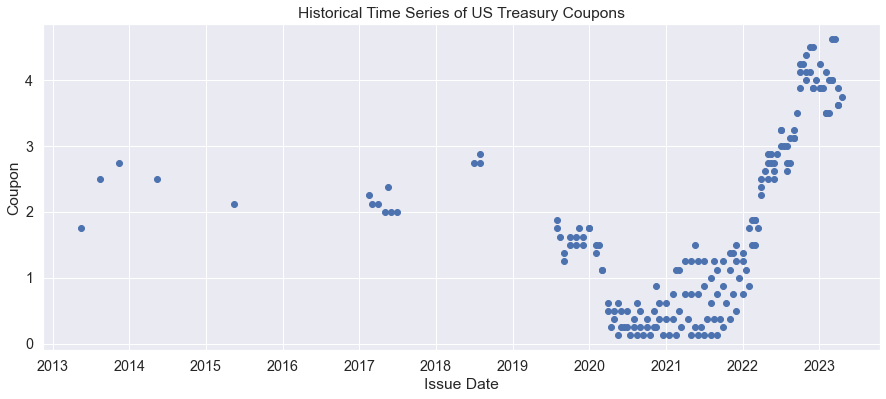

In [5]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.scatter(govt_symbology_plot['start_date'], govt_symbology_plot['coupon'])
plt.xlabel('Issue Date')
plt.ylabel('Coupon')
plt.title('Historical Time Series of US Treasury Coupons')
plt.show()

## c. Load the on-the-run US treasuries

Load the `govt_on_the_run` Excel file into a dataframe. Select the current on-the-run 2Y, 3Y, 5Y, 7Y, 10Y, 20Y and 30Y issues (off-the-run issues have the B & C suffix). Create a separate symbology dataframe for on-the-run treasuries only, to be used later on for the on-the-run government yield curve bootstrapping.

In [6]:
govt_all_issues = pd.read_excel('govt_on_the_run.xlsx')
govt_all_issues.head()

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT10B Govt,2023-04-14,US91282CFV81,BBG01BC373F4
2,GT10C Govt,2023-04-14,US91282CFF32,BBG01920ZBH5
3,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
4,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1


In [7]:
govt_on_the_run = govt_all_issues[~govt_all_issues['ticker'].str.contains('B|C')]
govt_on_the_run = govt_on_the_run.reset_index(drop=True)
govt_on_the_run

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
2,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1
3,GT3 Govt,2023-04-14,US91282CGV72,BBG01G5ZMM43
4,GT30 Govt,2023-04-14,US912810TN81,BBG01DVKBH56
5,GT5 Govt,2023-04-14,US91282CGT27,BBG01G14BW91
6,GT7 Govt,2023-04-14,US91282CGS44,BBG01G14BV75


In [8]:
otr = list(govt_on_the_run['isin'])
govt_symbology_otr = govt_symbology[govt_symbology['isin'].isin(otr)]
govt_symbology_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency,Term,TTM
138,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,2.00,1,2023-02-15,2023-08-15,2023-02-15,2053-02-15,US,USD,30.00,29.84
139,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,2.00,1,2023-02-28,2023-08-15,2023-02-15,2043-02-15,US,USD,19.96,19.84
373,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,2.00,1,2023-02-15,2023-08-15,2023-02-15,2033-02-15,US,USD,10.00,9.84
378,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,2.00,1,2023-03-31,2023-09-30,2023-03-31,2030-03-31,US,USD,7.00,6.96
379,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,2.00,1,2023-03-31,2023-09-30,2023-03-31,2028-03-31,US,USD,5.00,4.96
380,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,2.00,1,2023-03-31,2023-09-30,2023-03-31,2025-03-31,US,USD,2.00,1.96
381,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,2.00,1,2023-04-17,2023-10-15,2023-04-15,2026-04-15,US,USD,3.00,3.00


## d. Load and explore US corporate bonds symbology data

Load the `corp_symbology` Excel file into a dataframe. 

Create a new (filtered) dataframe for 
* bullet/non-callable (mty_typ="AT MATURITY"), 
* senior unsecured (rank = "Sr Unsecured"),
* fixed coupon (cpn_type="FIXED")

bonds only, with following columns:



| ticker | figi | security | name | coupon | start_date | maturity | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

where 
* `term` refers to the initial term/time-to-maturity in years
* `TTM` refers to the current time-to-maturity in years

Create a separate dataframe for VZ issuer only.

In [9]:
corp_symbology = pd.read_excel('corp_symbology.xlsx')
corp_symbology.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.70,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.70,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.38,...,2,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,US91282CGM73,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.55,...,2,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,AT MATURITY,Sr Unsecured,US,USD
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,US91282CGM73,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.20,...,2,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,AT MATURITY,Sr Unsecured,US,USD


In [10]:
corp_symbology_filtered = corp_symbology[corp_symbology['mty_typ'] == 'AT MATURITY']
corp_symbology_filtered = corp_symbology_filtered[corp_symbology_filtered['rank'] == 'Sr Unsecured']
corp_symbology_filtered = corp_symbology_filtered[corp_symbology_filtered['cpn_type'] == 'FIXED']

corp_symbology_filtered['Term'] = (corp_symbology_filtered['maturity'] - corp_symbology_filtered['start_date']).dt.days / 365.25
corp_symbology_filtered['Current'] = pd.to_datetime('2023-04-14')
corp_symbology_filtered['TTM'] = (corp_symbology_filtered['maturity'] - corp_symbology_filtered['Current']).dt.days / 365.25

keep = ['ticker', 'figi', 'security', 'name', 'coupon', 'start_date', 'maturity', 'Term', 'TTM']
corp_symbology_filtered = corp_symbology_filtered[corp_symbology_filtered.columns[corp_symbology_filtered.columns.isin(keep)]]
corp_symbology_filtered.head()


,ticker,figi,security,name,coupon,start_date,maturity,Term,TTM
3,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,6.55,2019-11-22,2033-03-15,13.31,9.92
4,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,6.20,2019-11-22,2034-12-15,15.06,11.67
5,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,6.40,2019-11-22,2035-12-15,16.06,12.67
6,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,6.15,2019-11-22,2037-03-01,17.27,13.88
7,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,6.65,2019-11-22,2037-11-15,17.98,14.59


In [11]:
corp_symbology_vz = corp_symbology_filtered[corp_symbology_filtered['ticker'] == 'VZ']
corp_symbology_vz

,ticker,figi,security,name,coupon,start_date,maturity,Term,TTM
181,VZ,BBG00000BHR9,VZ 6 1/4 04/01/37,VERIZON COMMUNICATIONS,6.25,2007-04-03,2037-04-01,30.00,13.97
182,VZ,BBG0000M1DD6,VZ 6.4 02/15/38,VERIZON COMMUNICATIONS,6.40,2008-02-12,2038-02-15,30.01,14.84
183,VZ,BBG0027BCJ08,VZ 4 3/4 11/01/41,VERIZON COMMUNICATIONS,4.75,2011-11-03,2041-11-01,30.00,18.55
185,VZ,BBG00580D503,VZ 6.4 09/15/33,VERIZON COMMUNICATIONS,6.40,2013-09-18,2033-09-15,19.99,10.42
186,VZ,BBG00580DD79,VZ 6.55 09/15/43,VERIZON COMMUNICATIONS,6.55,2013-09-18,2043-09-15,29.99,20.42
187,VZ,BBG0083CP3G1,VZ 4.862 08/21/46,VERIZON COMMUNICATIONS,4.86,2015-03-11,2046-08-21,31.45,23.35
188,VZ,BBG0083CP816,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,5.01,2015-03-11,2054-08-21,39.45,31.35
191,VZ,BBG009PNV1G8,VZ 4.272 01/15/36,VERIZON COMMUNICATIONS,4.27,2015-08-20,2036-01-15,20.41,12.76
192,VZ,BBG009PNW3Z2,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,4.52,2015-08-20,2048-09-15,33.07,25.42
193,VZ,BBG009PNW578,VZ 4.672 03/15/55,VERIZON COMMUNICATIONS,4.67,2015-08-20,2055-03-15,39.57,31.92


# Problem 2: Explore EOD market prices and yields

## a. Load and explore treasury market prices and yields

Load the `market_prices_eod` Excel file into a dataframe. It provides market data for US treasuries and corporate bonds of 2023-04-14.

Join the treasuries symbology dataframe with the market data, to add the following columns:


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of treasury mid yields by TTM.


In [12]:
market_prices_eod = pd.read_excel('market_prices_eod.xlsx')
market_prices_eod['mid_yield'] = (market_prices_eod['bid_yield'] + market_prices_eod['ask_yield'])/2
market_prices_eod = market_prices_eod.drop(['class', 'mid_clean', 'mid_dirty'], axis=1)
market_prices_eod.head()

,date,ticker,isin,figi,bid,ask,bid_yield,ask_yield,mid_yield
0,2023-04-14,DIS,US254687CZ75,BBG00QNKJ092,98.68,98.85,4.68,4.55,4.62
1,2023-04-14,DIS,US254687DD54,BBG00QNKPCL5,98.45,98.82,4.36,4.20,4.28
2,2023-04-14,DIS,US254687DK97,BBG00QNKGJP6,97.09,97.37,4.26,4.17,4.22
3,2023-04-14,DIS,US254687DV52,BBG00QNKP8R8,115.16,115.98,4.62,4.53,4.58
4,2023-04-14,DIS,US254687DZ66,BBG00QNKR4J4,112.94,113.59,4.74,4.67,4.71


In [13]:
govt_merged = govt_symbology.merge(market_prices_eod, on=['ticker', 'figi', 'isin'])
govt_merged.head()

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,country,currency,Term,TTM,date,bid,ask,bid_yield,ask_yield,mid_yield
0,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.25,FIXED,...,US,USD,30.00,0.34,2023-04-14,100.44,100.88,4.86,3.54,4.20
1,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.50,FIXED,...,US,USD,30.25,1.59,2023-04-14,104.77,105.21,4.34,4.05,4.19
2,T,Govt,BBG000DLBVY0,US912810ET17,TSRYS4493812,T 7 5/8 02/15/25,US TREASURY N/B,US GOVERNMENT,7.62,FIXED,...,US,USD,30.00,1.84,2023-04-14,105.93,106.35,4.22,3.99,4.11
3,T,Govt,BBG000DQQNJ8,US912810EV62,TSRYS4493813,T 6 7/8 08/15/25,US TREASURY N/B,US GOVERNMENT,6.88,FIXED,...,US,USD,30.00,2.34,2023-04-14,106.26,106.93,4.03,3.74,3.89
4,T,Govt,BBG000DPXMD0,US912810EW46,TSRYS4493814,T 6 02/15/26,US TREASURY N/B,US GOVERNMENT,6.00,FIXED,...,US,USD,30.00,2.84,2023-04-14,105.45,106.05,3.95,3.73,3.84


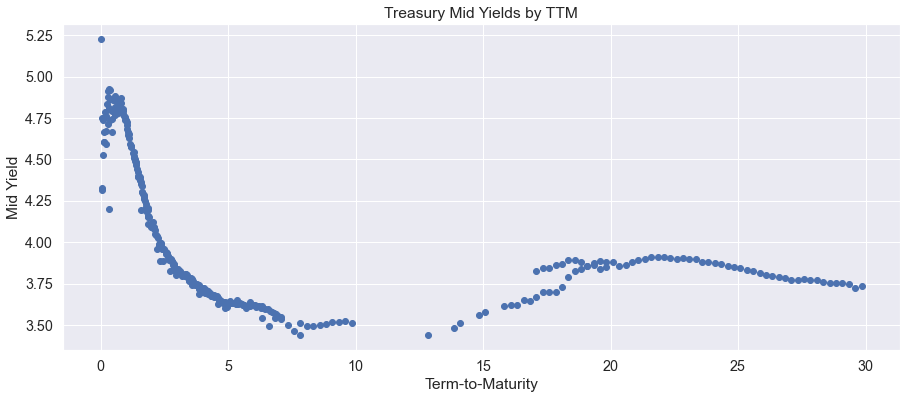

In [14]:
plt.scatter(govt_merged['TTM'], govt_merged['mid_yield'])
plt.xlabel('Term-to-Maturity')
plt.ylabel('Mid Yield')
plt.title('Treasury Mid Yields by TTM')
plt.show()

## b. Explore on-the-run treasuries only
Create a separate joint dataframe for on-the-run treasuries only.

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

In [15]:
govt_merged_otr = govt_symbology_otr.merge(market_prices_eod, on=['ticker', 'figi', 'isin'])
govt_merged_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,country,currency,Term,TTM,date,bid,ask,bid_yield,ask_yield,mid_yield
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,US,USD,30.00,29.84,2023-04-14,97.95,98.03,3.74,3.73,3.74
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,US,USD,19.96,19.84,2023-04-14,100.30,100.38,3.85,3.85,3.85
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,US,USD,10.00,9.84,2023-04-14,99.84,99.89,3.52,3.51,3.52
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,US,USD,7.00,6.96,2023-04-14,100.38,100.44,3.56,3.55,3.56
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,US,USD,5.00,4.96,2023-04-14,100.07,100.09,3.61,3.61,3.61
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,US,USD,2.00,1.96,2023-04-14,99.57,99.58,4.11,4.10,4.10
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,US,USD,3.00,3.00,2023-04-14,99.76,99.77,3.84,3.83,3.83


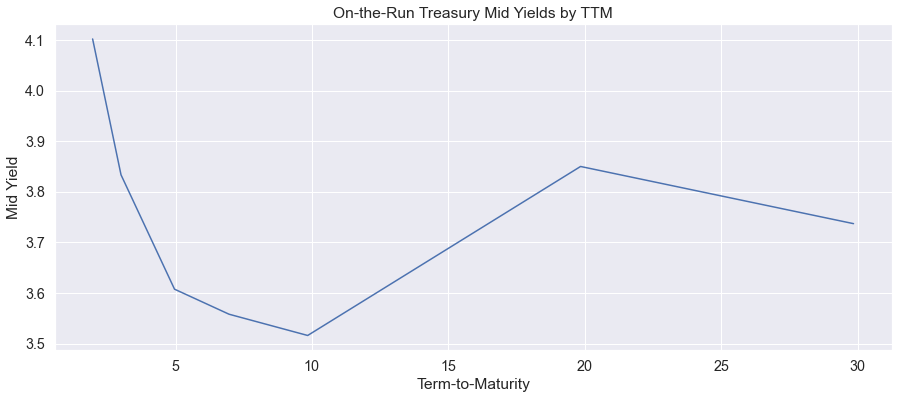

In [16]:
plt.plot(govt_merged_otr.sort_values('TTM')['TTM'], govt_merged_otr.sort_values('TTM')['mid_yield'])
plt.xlabel('Term-to-Maturity')
plt.ylabel('Mid Yield')
plt.title('On-the-Run Treasury Mid Yields by TTM')
plt.show()

## c. Load and explore corporate bond market prices and yields

Join the filtered corporate bonds symbology dataframe with the market data, to add the following columns:


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

List the unique tickers/issuers available in the dataframe.

In [17]:
corp_merged = corp_symbology_filtered.merge(market_prices_eod, on=['ticker', 'figi'])
corp_merged = corp_merged.drop(['isin'], axis=1)
corp_merged.head()

,ticker,figi,security,name,coupon,start_date,maturity,Term,TTM,date,bid,ask,bid_yield,ask_yield,mid_yield
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,6.55,2019-11-22,2033-03-15,13.31,9.92,2023-04-14,115.16,115.98,4.62,4.53,4.58
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,6.20,2019-11-22,2034-12-15,15.06,11.67,2023-04-14,112.94,113.59,4.74,4.67,4.71
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,6.40,2019-11-22,2035-12-15,16.06,12.67,2023-04-14,114.64,115.44,4.84,4.76,4.80
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,6.15,2019-11-22,2037-03-01,17.27,13.88,2023-04-14,111.15,112.38,5.02,4.91,4.97
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,6.65,2019-11-22,2037-11-15,17.98,14.59,2023-04-14,118.14,119.17,4.89,4.80,4.85


In [18]:
corp_merged['ticker'].unique()

array(['DIS', 'IBM', 'MS', 'ORCL', 'VZ'], dtype=object)

In [19]:
corp_merged['name'].unique()

array(['WALT DISNEY COMPANY/THE', 'TWDC ENTERPRISES 18 CORP', 'IBM CORP',
       'MORGAN STANLEY', 'EATON VANCE CORP', 'ORACLE CORP',
       'VERIZON COMMUNICATIONS'], dtype=object)

## d. Yield curve plots

Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).

Add a separate line for on-the-run US treasury yield curve (risk free curve).

What can you say about the credit issuer yields, compared to US treasury yields?

**Answer:**
- Credit issuer yields are seen to be higher than US Treasury yields
- The reason behind this observation is that there is a higher credit risk associated with corporate bonds compared to US Treasury bonds (which are considered risk free)
- Corporate bonds are issued by companies to raise capital, and the yield on these bonds reflects the risk that investors perceive the company will default on its debt obligations
- US Treasury bonds, on the other hand, are issued by the US government and are considered to be among the safest investments in the world

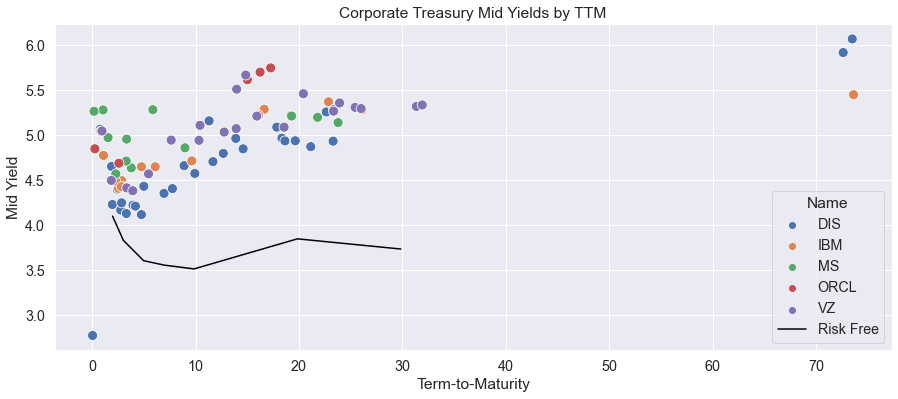

In [20]:
govt_merged_otr['Name'] = 'Risk Free'

sns.scatterplot(data=corp_merged, x='TTM', y='mid_yield', hue='ticker', s=100)
sns.lineplot(data=govt_merged_otr.sort_values('TTM'), x='TTM', y='mid_yield', hue='Name', palette=['black'])
plt.xlabel('Term-to-Maturity')
plt.ylabel('Mid Yield')
plt.title('Corporate Treasury Mid Yields by TTM')
plt.show()

**Zooming in to 0-30 TTM for better clarity**

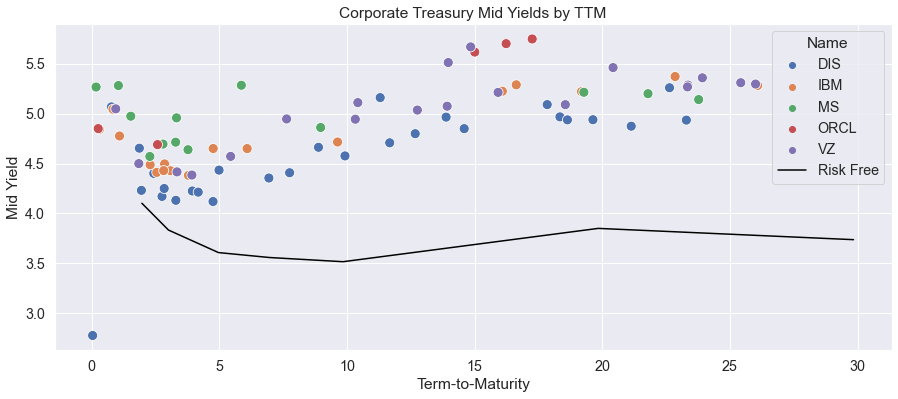

In [21]:
corp_merged_zoomed = corp_merged[corp_merged['TTM'] <= 30]

sns.scatterplot(data=corp_merged_zoomed, x='TTM', y='mid_yield', hue='ticker', s=100)
sns.lineplot(data=govt_merged_otr.sort_values('TTM'), x='TTM', y='mid_yield', hue='Name', palette=['black'])
plt.xlabel('Term-to-Maturity')
plt.ylabel('Mid Yield')
plt.title('Corporate Treasury Mid Yields by TTM')
plt.show()

# Problem 3: Underying treasury benchmarks and credit spreads

## a. Add underlying benchmark bond mid yields

Use the column 'und_bench_yield' to identify the underlying benchmark bond for each issue.

Add two new columns to the joint corporate bond dataframe:

| und_bench_yield | credit_spread |
|----------|-------|

where 

*  `und_bench_yield` = underlying benchmark bond mid yield and
*  `credit_spread` = issue yield - underlying benchmark bond mid yield.

In [22]:
corp_symbology_und = corp_symbology[['figi', 'und_bench_isin']]
corp_merged = corp_merged.merge(corp_symbology_und, on=['figi'])
corp_merged.head()

,ticker,figi,security,name,coupon,start_date,maturity,Term,TTM,date,bid,ask,bid_yield,ask_yield,mid_yield,und_bench_isin
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,6.55,2019-11-22,2033-03-15,13.31,9.92,2023-04-14,115.16,115.98,4.62,4.53,4.58,US91282CGM73
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,6.20,2019-11-22,2034-12-15,15.06,11.67,2023-04-14,112.94,113.59,4.74,4.67,4.71,US91282CGM73
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,6.40,2019-11-22,2035-12-15,16.06,12.67,2023-04-14,114.64,115.44,4.84,4.76,4.80,US91282CGM73
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,6.15,2019-11-22,2037-03-01,17.27,13.88,2023-04-14,111.15,112.38,5.02,4.91,4.97,US91282CGM73
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,6.65,2019-11-22,2037-11-15,17.98,14.59,2023-04-14,118.14,119.17,4.89,4.80,4.85,US91282CGM73


In [23]:
market_prices_eod_filtered = market_prices_eod[['isin', 'mid_yield']]
corp_merged = corp_merged.merge(market_prices_eod_filtered, left_on=['und_bench_isin'], right_on=['isin'])
corp_merged = corp_merged.rename(columns={'mid_yield_y':'und_bench_yield', 'mid_yield_x': 'mid_yield'})
corp_merged['credit_spread'] = corp_merged['mid_yield'] - corp_merged['und_bench_yield']
corp_merged = corp_merged.drop(['isin'], axis=1)
corp_merged.head()

,ticker,figi,security,name,coupon,start_date,maturity,Term,TTM,date,bid,ask,bid_yield,ask_yield,mid_yield,und_bench_isin,und_bench_yield,credit_spread
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,6.55,2019-11-22,2033-03-15,13.31,9.92,2023-04-14,115.16,115.98,4.62,4.53,4.58,US91282CGM73,3.52,1.06
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,6.20,2019-11-22,2034-12-15,15.06,11.67,2023-04-14,112.94,113.59,4.74,4.67,4.71,US91282CGM73,3.52,1.19
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,6.40,2019-11-22,2035-12-15,16.06,12.67,2023-04-14,114.64,115.44,4.84,4.76,4.80,US91282CGM73,3.52,1.28
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,6.15,2019-11-22,2037-03-01,17.27,13.88,2023-04-14,111.15,112.38,5.02,4.91,4.97,US91282CGM73,3.52,1.45
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,6.65,2019-11-22,2037-11-15,17.98,14.59,2023-04-14,118.14,119.17,4.89,4.80,4.85,US91282CGM73,3.52,1.33


## b. Credit spread curve plots

Plot a graph/scatter plot of credit spread curves by TTM (one line per issuer).


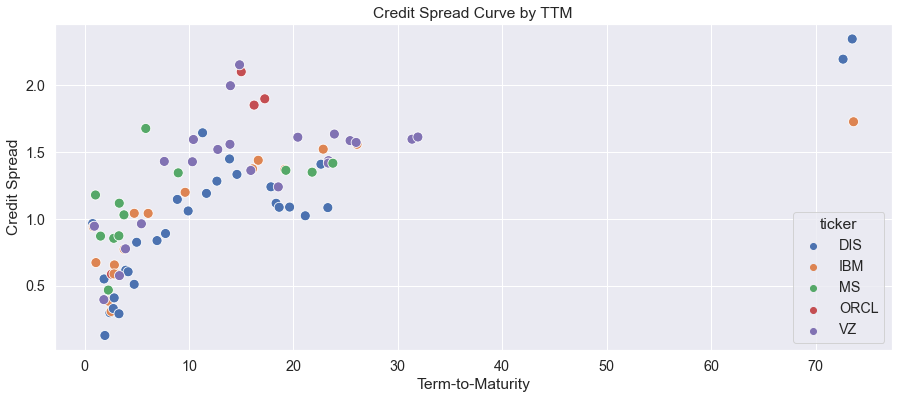

In [24]:
sns.scatterplot(data=corp_merged, x='TTM', y='credit_spread', hue='ticker', s=100)
plt.xlabel('Term-to-Maturity')
plt.ylabel('Credit Spread')
plt.title('Credit Spread Curve by TTM')
plt.show()

## c. Add g-spreads

Add two new columns to the joint corporate bond dataframe:

| interp_tsy_yield | g_spread |
|----------|-------|

where 

*  `interp_tsy_yield` = interpolated treasury yield (using on-the-run treasuries only), matching the issue maturity
*  `g_spread` = issue yield - interp_tsy_yield.

In [25]:
govt_merged_otr_filtered = govt_merged_otr[['maturity', 'mid_yield']]
corp_merged = pd.merge_asof(corp_merged.sort_values('maturity'), govt_merged_otr_filtered.sort_values('maturity'), \
                            on='maturity', direction='nearest')
corp_merged = corp_merged.rename(columns={'mid_yield_y':'interp_tsy_yield', 'mid_yield_x': 'mid_yield'})
corp_merged['g_spread'] = corp_merged['mid_yield'] - corp_merged['interp_tsy_yield']
corp_merged.head()

,ticker,figi,security,name,coupon,start_date,maturity,Term,TTM,date,bid,ask,bid_yield,ask_yield,mid_yield,und_bench_isin,und_bench_yield,credit_spread,interp_tsy_yield,g_spread
0,DIS,BBG00N36B7D0,DIS 7 3/4 01/20/24,WALT DISNEY COMPANY/THE,7.75,2019-03-20,2024-01-20,4.84,0.77,2023-04-14,101.74,102.17,5.35,4.78,5.07,US91282CGU99,4.10,0.97,4.10,0.97
1,IBM,BBG005ZC4J89,IBM 3 5/8 02/12/24,IBM CORP,3.62,2014-02-12,2024-02-12,10.00,0.83,2023-04-14,98.75,99.00,5.21,4.88,5.04,US91282CGU99,4.10,0.94,4.10,0.94
2,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,0.75,2021-03-22,2024-03-22,3.00,0.94,2023-04-14,95.97,96.33,5.25,4.85,5.05,US91282CGU99,4.10,0.95,4.10,0.95
3,MS,BBG006DDT5Z2,MS 3 7/8 04/29/24,MORGAN STANLEY,3.88,2014-04-28,2024-04-29,10.00,1.04,2023-04-14,98.47,98.74,5.42,5.14,5.28,US91282CGU99,4.10,1.18,4.10,1.18
4,IBM,BBG00P3BLGV3,IBM 3 05/15/24,IBM CORP,3.00,2019-05-15,2024-05-15,5.00,1.09,2023-04-14,98.06,98.26,4.88,4.68,4.78,US91282CGU99,4.10,0.67,4.10,0.67


## d. G-spread curve plots

Plot a graph/scatter plot of g-spread curves by TTM (one line per issuer).


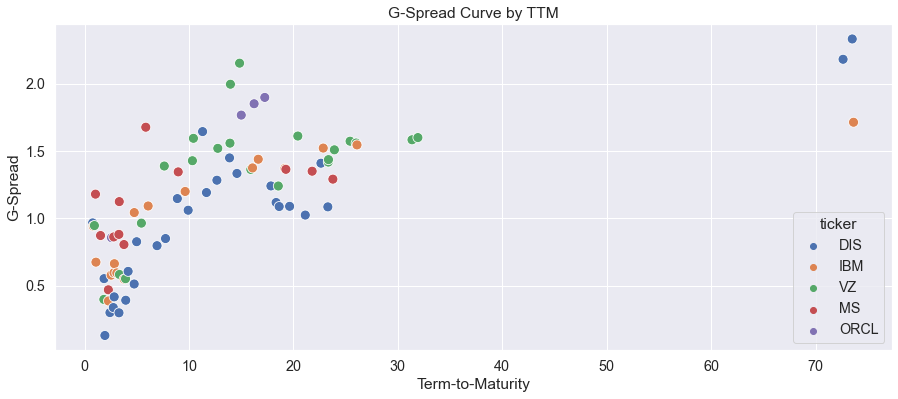

In [26]:
sns.scatterplot(data=corp_merged, x='TTM', y='g_spread', hue='ticker', s=100)
plt.xlabel('Term-to-Maturity')
plt.ylabel('G-Spread')
plt.title('G-Spread Curve by TTM')
plt.show()

# Problem 4: Explore the QuantLib introductory notebook

Try to link concepts discussed in Session 1 to various sections in the notebook. 

Address open questions by consulting the library documentation.

Going forward, we will be using QuantLib for curve calibration (US Treasury + SOFR), as well as pricing and risk of various cash and synthetic credit instruments.

**Answer:**

I will be using QuantLib to check whether the approach taken in Problem 2 of averaging the bid yield and the ask yield to get to the mid yield is the same as what we would get if we were to use QuantLib functions to calculate the mid yield using the mid clean price.

I will be testing this for two cases to see how close the mid yields are.

In [27]:
market_prices_orig = pd.read_excel('market_prices_eod.xlsx')
market_prices_orig['mid_yield'] = (market_prices_orig['bid_yield'] + market_prices_orig['ask_yield'])/2

test = govt_symbology.merge(market_prices_orig, on=['ticker', 'figi', 'isin'])

test.iloc[:, [3, 8, 10, 11, 12, 13, 14, 16, 21, 25, 29]].head(2)

,isin,coupon,dcc,cpn_freq,days_settle,start_date,cpn_first,maturity,date,mid_clean,mid_yield
0,US912810EQ77,6.25,ACT/ACT,2.00,1,1993-08-16,1994-02-15,2023-08-15,2023-04-14,100.66,4.20
1,US912810ES34,7.50,ACT/ACT,2.00,1,1994-08-15,1994-11-15,2024-11-15,2023-04-14,104.99,4.19


#### Case 1: ISIN US912810EQ77

In [28]:
issue_date = ql.Date(16, 8, 1993)
first_date = ql.Date(15, 2, 1994)
maturity_date = ql.Date(15, 8, 2023)
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = False
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end,
                       first_date)

In [29]:
print("All dates: ", list(schedule))

All dates:  [Date(16,8,1993), Date(15,2,1994), Date(15,8,1994), Date(15,2,1995), Date(15,8,1995), Date(15,2,1996), Date(15,8,1996), Date(15,2,1997), Date(15,8,1997), Date(15,2,1998), Date(15,8,1998), Date(15,2,1999), Date(15,8,1999), Date(15,2,2000), Date(15,8,2000), Date(15,2,2001), Date(15,8,2001), Date(15,2,2002), Date(15,8,2002), Date(15,2,2003), Date(15,8,2003), Date(15,2,2004), Date(15,8,2004), Date(15,2,2005), Date(15,8,2005), Date(15,2,2006), Date(15,8,2006), Date(15,2,2007), Date(15,8,2007), Date(15,2,2008), Date(15,8,2008), Date(15,2,2009), Date(15,8,2009), Date(15,2,2010), Date(15,8,2010), Date(15,2,2011), Date(15,8,2011), Date(15,2,2012), Date(15,8,2012), Date(15,2,2013), Date(15,8,2013), Date(15,2,2014), Date(15,8,2014), Date(15,2,2015), Date(15,8,2015), Date(15,2,2016), Date(15,8,2016), Date(15,2,2017), Date(15,8,2017), Date(15,2,2018), Date(15,8,2018), Date(15,2,2019), Date(15,8,2019), Date(15,2,2020), Date(15,8,2020), Date(15,2,2021), Date(15,8,2021), Date(15,2,2022), D

In [30]:
coupon_rate = 0.0625
day_count = ql.ActualActual(ql.ActualActual.ISMA)
coupons = [coupon_rate]

# Construct the FixedRateBond
settlement_days = 1
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    schedule,
    coupons,
    day_count)

In [31]:
x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date, cf_amount = zip(*x)
cf_frame = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
print(cf_frame)

           CashFlowDate  CashFlowAmount
0   February 15th, 1994            3.11
1     August 15th, 1994            3.12
2   February 15th, 1995            3.12
3     August 15th, 1995            3.12
4   February 15th, 1996            3.12
..                  ...             ...
56  February 15th, 2022            3.12
57    August 15th, 2022            3.12
58  February 15th, 2023            3.12
59    August 15th, 2023            3.12
60    August 15th, 2023          100.00

[61 rows x 2 columns]


In [32]:
bond_market_price = 100.66

compounding = ql.Compounded
calc_date = ql.Date(14, 4, 2023)

settle_date = fixed_rate_bond.settlementDate(calc_date)
day_counter = fixed_rate_bond.dayCounter()

print('day_counter =', day_counter)
print('coupon_freq =', coupon_freq)
print('calc_date =', calc_date)
print('settle_date =', settle_date)

implied_yield = fixed_rate_bond.bondYield(bond_market_price, day_counter, compounding, coupon_freq, settle_date) * 100
print('implied_yield =', implied_yield)

day_counter = Actual/Actual (ISMA) day counter
coupon_freq = 2
calc_date = April 14th, 2023
settle_date = April 17th, 2023
implied_yield = 4.202003526687623


In [33]:
print('Difference =', '{:.2f}'.format(implied_yield - test.loc[0, 'mid_yield']))

Difference = 0.00


#### Case 2: ISIN US912810ES34

In [34]:
issue_date = ql.Date(15, 8, 1994)
first_date = ql.Date(15, 11, 1994)
maturity_date = ql.Date(15, 11, 2024)
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = False
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end,
                       first_date)

In [35]:
print("All dates: ", list(schedule))

All dates:  [Date(15,8,1994), Date(15,11,1994), Date(15,5,1995), Date(15,11,1995), Date(15,5,1996), Date(15,11,1996), Date(15,5,1997), Date(15,11,1997), Date(15,5,1998), Date(15,11,1998), Date(15,5,1999), Date(15,11,1999), Date(15,5,2000), Date(15,11,2000), Date(15,5,2001), Date(15,11,2001), Date(15,5,2002), Date(15,11,2002), Date(15,5,2003), Date(15,11,2003), Date(15,5,2004), Date(15,11,2004), Date(15,5,2005), Date(15,11,2005), Date(15,5,2006), Date(15,11,2006), Date(15,5,2007), Date(15,11,2007), Date(15,5,2008), Date(15,11,2008), Date(15,5,2009), Date(15,11,2009), Date(15,5,2010), Date(15,11,2010), Date(15,5,2011), Date(15,11,2011), Date(15,5,2012), Date(15,11,2012), Date(15,5,2013), Date(15,11,2013), Date(15,5,2014), Date(15,11,2014), Date(15,5,2015), Date(15,11,2015), Date(15,5,2016), Date(15,11,2016), Date(15,5,2017), Date(15,11,2017), Date(15,5,2018), Date(15,11,2018), Date(15,5,2019), Date(15,11,2019), Date(15,5,2020), Date(15,11,2020), Date(15,5,2021), Date(15,11,2021), Date(15

In [36]:
coupon_rate = 0.075
day_count = ql.ActualActual(ql.ActualActual.ISMA)
coupons = [coupon_rate]

# Construct the FixedRateBond
settlement_days = 1
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    schedule,
    coupons,
    day_count)

In [37]:
x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date, cf_amount = zip(*x)
cf_frame = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
print(cf_frame)

           CashFlowDate  CashFlowAmount
0   November 15th, 1994            1.88
1        May 15th, 1995            3.75
2   November 15th, 1995            3.75
3        May 15th, 1996            3.75
4   November 15th, 1996            3.75
..                  ...             ...
57       May 15th, 2023            3.75
58  November 15th, 2023            3.75
59       May 15th, 2024            3.75
60  November 15th, 2024            3.75
61  November 15th, 2024          100.00

[62 rows x 2 columns]


In [38]:
bond_market_price = 104.99

compounding = ql.Compounded
calc_date = ql.Date(14, 4, 2023)

settle_date = fixed_rate_bond.settlementDate(calc_date)
day_counter = fixed_rate_bond.dayCounter()

print('day_counter =', day_counter)
print('coupon_freq =', coupon_freq)
print('calc_date =', calc_date)
print('settle_date =', settle_date)

implied_yield = fixed_rate_bond.bondYield(bond_market_price, day_counter, compounding, coupon_freq, settle_date) * 100
print('implied_yield =', implied_yield)

day_counter = Actual/Actual (ISMA) day counter
coupon_freq = 2
calc_date = April 14th, 2023
settle_date = April 17th, 2023
implied_yield = 4.194241285324098


In [39]:
print('Difference =', '{:.2f}'.format(implied_yield - test.loc[1, 'mid_yield']))

Difference = 0.00


**Conclusion:** Up to 2 decimal places, the method of averaging the bid yield and the ask yield to get to the mid yield gives us the same results as using QuantLib functions to calculate the mid yield.